
# Understanding semantics clusters in presidential speeches using topic modeling

In this notebook we use topic modeling using LDA as well as word embeddings to understand the semantic space 
of presidential speeches.

In [11]:
import sys
sys.path.append("c:\\Users\\robal\\Dropbox\\UChicago\\Year II\\Quarter II\\Computational Content Analysis\\final_project")

In [28]:
import lucem_illud 
from ContentAnalysisPresidentialRhetoric.utils.utils import *
from ContentAnalysisPresidentialRhetoric.topic_modeling.TopicModeling import TopicModels as LDA_barrosoluquer
from ContentAnalysisPresidentialRhetoric.topic_modeling.PrepareText import PrepareText
%load_ext autoreload
%autoreload 2

import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import gensim
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np 
import pandas as pandas
import matplotlib.pyplot as plt 
import matplotlib.cm 
import seaborn as sns

%matplotlib inline

import itertools
import json

SentimentScorer = SentimentIntensityAnalyzer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Topic modeling on presidential speeches

In [19]:
speeches = pd.read_excel(r"../data/presidential_speeches.xlsx")
speeches = speeches.drop(columns="Unnamed: 0")
speeches["Speech"] = speeches.Speech.apply(lambda row: clean_raw_text([row])[0])
speeches['tokenized_text'] = speeches['Speech'].apply(lambda x: lucem_illud.word_tokenize(x))
speeches['normalized_text'] = speeches['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
speeches.head()

,President,Date,Speech,tokenized_text,normalized_text
0,Joe Biden,"January 20, 2021","Chief Justice Roberts, Vice President Harris, ...","[Chief, Justice, Roberts, Vice, President, Har...","[chief, justice, roberts, vice, president, har..."
1,Donald Trump,"January 19, 2021","My fellow Americans: Four years ago, we launch...","[My, fellow, Americans, Four, years, ago, we, ...","[fellow, americans, year, ago, launch, great, ..."
2,Donald Trump,"January 13, 2021","My fellow Americans,I want to speak to you ton...","[My, fellow, Americans, I, want, to, speak, to...","[fellow, americans, want, speak, tonight, trou..."
3,Donald Trump,"January 07, 2021",I would like to begin by addressing the heinou...,"[I, would, like, to, begin, by, addressing, th...","[like, begin, address, heinous, attack, unite,..."
4,Donald Trump,"January 06, 2021",I know your pain. I know your hurt.We had an e...,"[I, know, your, pain, I, know, your, hurt, We,...","[know, pain, know, hurt, election, steal, land..."


In [20]:
speeches.President.unique()

array(['Joe Biden', 'Donald Trump', 'Barack Obama', 'George W. Bush',
       'Bill Clinton', 'George H. W. Bush', 'Ronald Reagan',
       'Jimmy Carter', 'Gerald Ford', 'Richard M. Nixon',
       'Lyndon B. Johnson', 'John F. Kennedy'], dtype=object)

In [21]:
speeches_tfidf_vect = vectorize_documents(speeches, "Speech", "tfidf")
X_speeches = speeches_tfidf_vect.toarray()

I have previously developed a class for topic modeling and cleaning which I will use here (no need to re-invent the wheel). Please se the TopicModeling.py and PrepareText.py file to see the my implementations.

In [25]:
speeches_docs = [doc for doc in speeches.Speech.values]
# Clean documents and prepare for LDA
clean_speeches = PrepareText(speeches_docs)

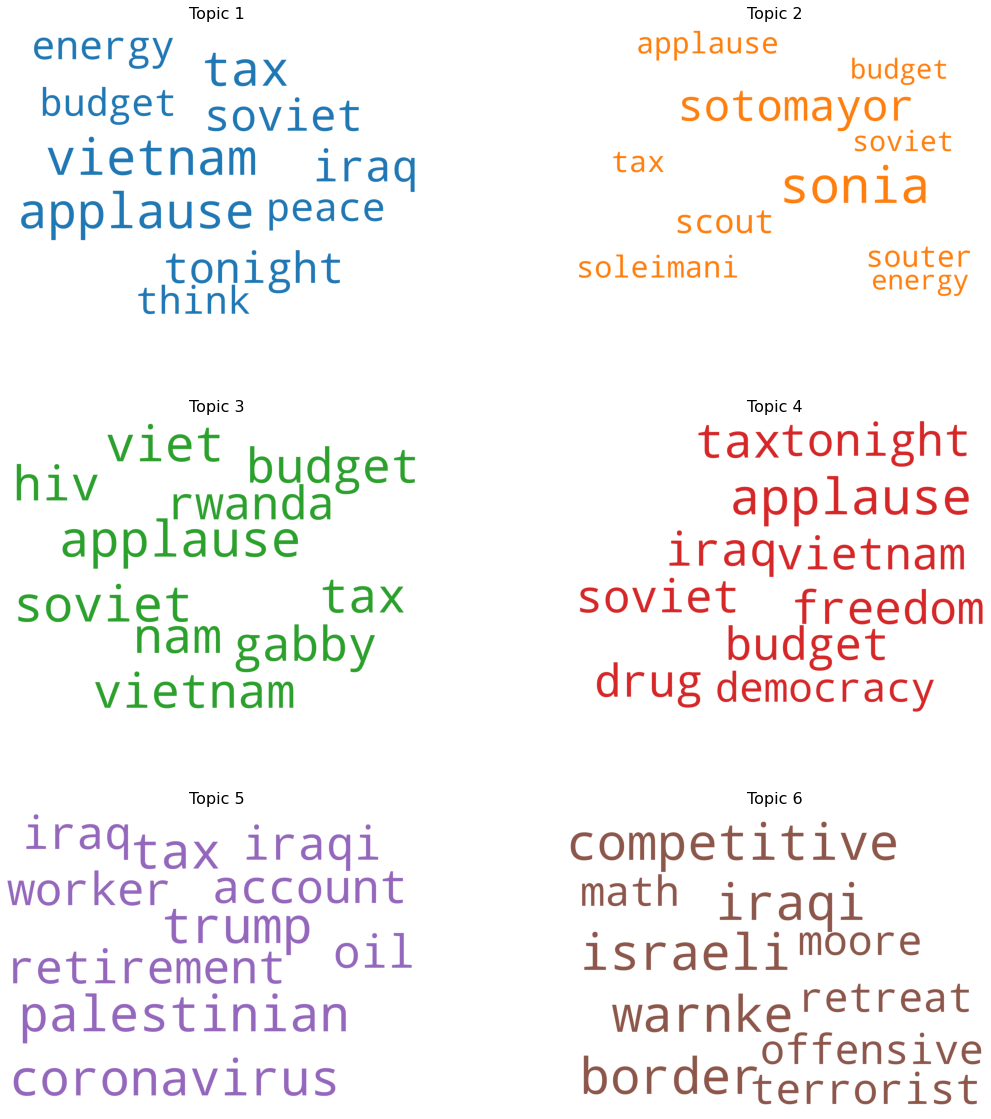

In [27]:
# Use TopicModels class to apply LDA use k = 6 initially
lda_speeches = LDA_barrosoluquer(clean_speeches)
lda_speeches_6 = lda_speeches.applyLDA(numtopics=6)
lda_speeches.generate_topic_wordcloud(lda_speeches_6)

Above we can see a wordcloud for the 6 generated topics. It seems that while some topics are obviously separate,
for example topic 1 seems to be about foreign wars and topic 5 seems to be about genetic research, there is 
definetly overlap around topics topic 1 and topic 3 for example seem to share some top words. Below we use gridsearch to
optimize for coherence score varying alpha, eta and k.

In [47]:
# Run grid serach by varying hyperparams
params_grid = {
     'alpha_range':[.6,.8, 1],
     'beta_range':[.6,.8, 1],
     'num_topics_range': [10,15,20]}
results_df = lda_speeches.grid_search(params_grid)
results_df

,Models,alpha,beta,num_topics,coherence_score
72,"LdaModel(num_terms=11944, num_topics=10, decay...",0.6,0.6,10,0.432312
137,"LdaModel(num_terms=11944, num_topics=10, decay...",1,0.8,10,0.377574
157,"LdaModel(num_terms=11944, num_topics=10, decay...",asymmetric,0.4,10,0.377051
168,"LdaModel(num_terms=11944, num_topics=15, decay...",asymmetric,0.8,15,0.375680
13,"LdaModel(num_terms=11944, num_topics=15, decay...",0.2,0.6,15,0.371144
...,...,...,...,...,...
144,"LdaModel(num_terms=11944, num_topics=20, decay...",1,1,20,0.265989
15,"LdaModel(num_terms=11944, num_topics=2, decay=...",0.2,0.8,2,0.265758
25,"LdaModel(num_terms=11944, num_topics=2, decay=...",0.2,symmetric,2,0.259856
50,"LdaModel(num_terms=11944, num_topics=2, decay=...",0.4,1,2,0.256250


In [48]:
results_df.head(1)

,Models,alpha,beta,num_topics,coherence_score
72,"LdaModel(num_terms=11944, num_topics=10, decay...",0.6,0.6,10,0.432312


From the above grid search we find the parameters that optimize coherence score are alpha=.6, beta=.6 and k = 10. Furthermore, it is clear
from the results dataframe that the most important parameter for the speeches corpus seems to be the number of topics chosen.
We can use the LDAmodel saved in the results dataframe to understand the topics of the optimal model by exploring the word distributions.

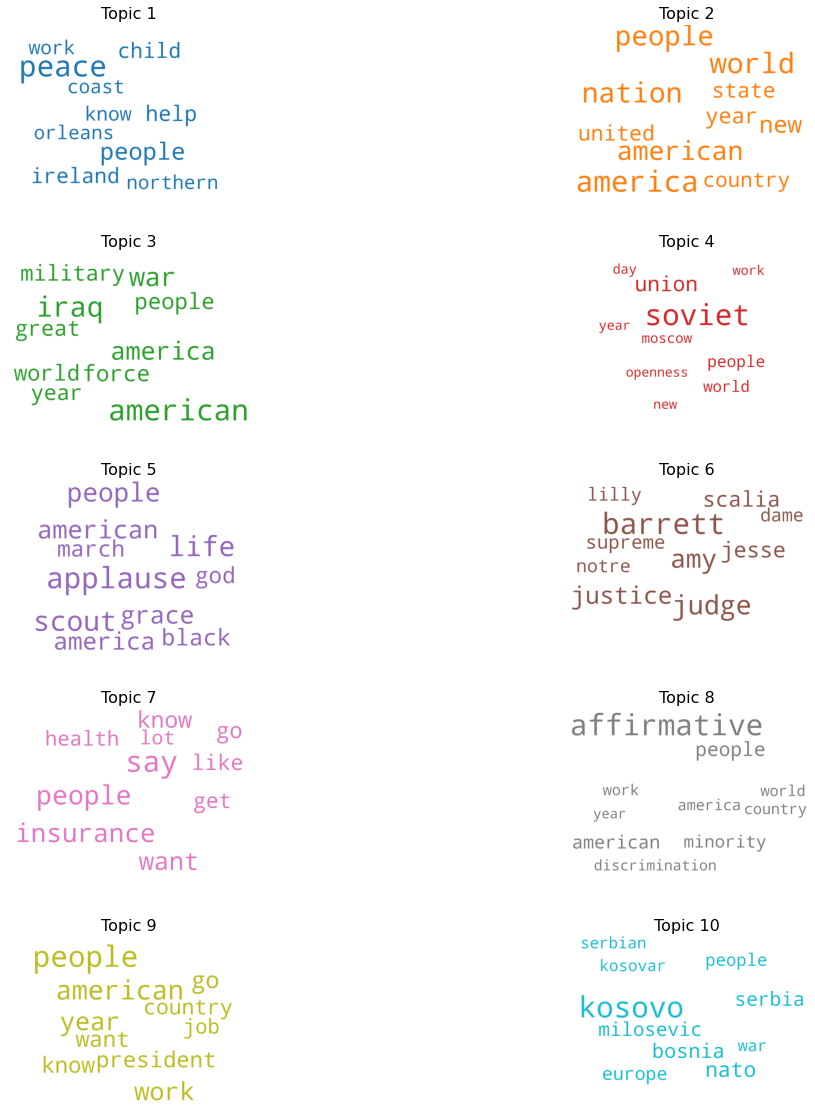

In [51]:
lda_speeches.generate_topic_wordcloud(ldamodel=results_df.iloc[0,0])

Just judging on the distributions of our optimal model from grid search and the first "naive" model we implemented
we see drastic improvements. The optimal model shows 10 distinc clusters with coherent topics my subjective labels for the 
above topics would be as follows:

Topic 1: Welfare and aid.

Topic 2: America and the world.

Topic 3: Foreign wars.

Topic 4: Great power rivalry.

Topic 5: Celebrations.

Topic 6: Supreme Court.

Topic 7: Health insurance.

Topic 8: Diversity/inclusion.

Topic 9: The people's president.

Topic 10: Nato and proxy wars.

We can now check what topic each president talk the most about in their speeches first speech.

In [67]:
topics_speeches = results_df.iloc[0,0].get_document_topics(bow=lda_speeches.corpus)
for president in speeches.President.unique():
    first_speech_idx = speeches.loc[speeches.President == president].first_valid_index()
    print(f"President {president} spoke about {topics_speeches[first_speech_idx]} in his first speech")
    print()

President Joe Biden spoke about [(1, 0.8892383), (8, 0.10393919)] in his first speech

President Donald Trump spoke about [(1, 0.5088657), (8, 0.4859044)] in his first speech

President Barack Obama spoke about [(1, 0.076187685), (8, 0.92046213)] in his first speech

President George W. Bush spoke about [(1, 0.98659223)] in his first speech

President Bill Clinton spoke about [(1, 0.70544654), (8, 0.2830358)] in his first speech

President George H. W. Bush spoke about [(1, 0.9609591), (8, 0.034570873)] in his first speech



This is very interesting, it seems that all presidents mainly spoke about topic 1 and topic 8 in their first speech, the main difference
is which of these two topics they spoke about more. For example it seems Joe Biden mainly talked the "Welfare and Aid" topic while president Obama
mostly spoke about the Diversity and inclusion topic. In general, however, both of these topics are about positively valenced subjects, which makes
sense since presumably the first speech of each president is the inaugural address.

Below we can check the distribution of topics for each 

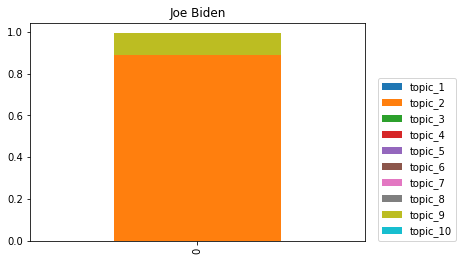

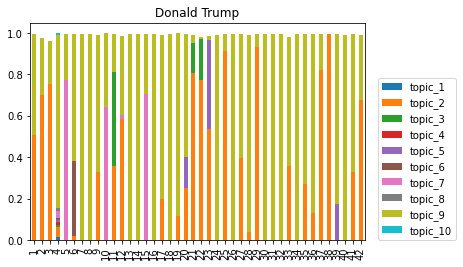

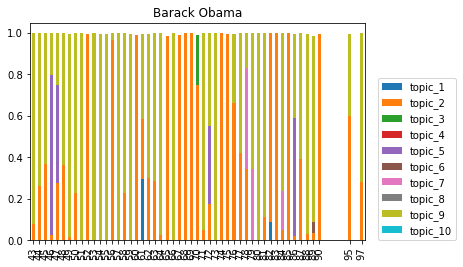

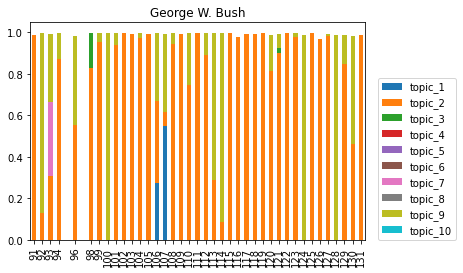

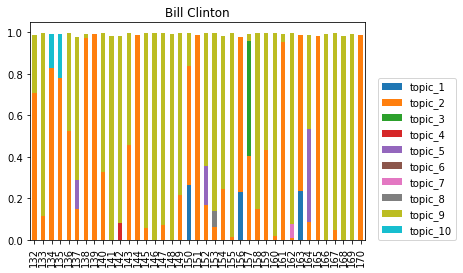

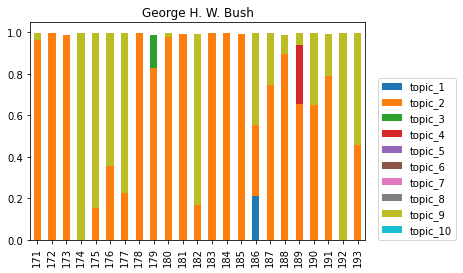

In [111]:
for president in speeches.President.unique():
    speech_idx = speeches.loc[speeches.President == president].index.tolist()
    speech_idx.reverse()
    lda_speeches.generate_bar_plot(ldamodel=results_df.iloc[0,0], docs_to_view=speech_idx, title=president)

It seems that topic 2 and topic 9 are by far the most spoken about topics across speeches of presidents.
However, some interesting patters have emerged, Obama seems to speak a lot about topic 5 (celebrations) and topic 7 (health insurance). 
This is actually incredible, LDA seems to have captured, correctly, that one of Obama's signature legislations was around health insurance 
, aka the Affordable Care Act. Furthemore, George W Bush seems to have given a speech largely about great power rivalry towards the end
of his presidency.

# Word Embeddings


In [29]:
party_affiliation = {"Joe Biden":"Democrat", "Donald Trump": "Republican",
                     "Barack Obama": "Democrat", "George W. Bush": "Republican",
                     "Bill Clinton": "Democrat", "George H. W. Bush": "Republican",
                     "Ronald Reagan": "Republican", "Jimmy Carter": "Democrat",
                     "Gerald Ford": "Republican", "Richard M. Nixon":"Republican",
                     "Lyndon B. Johnson":"Democrat", "John F. Kennedy": "Republican"}

In [35]:
speeches['tokenized_sentences'] = speeches['Speech'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
speeches['normalized_sentences'] = speeches['tokenized_sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [38]:
speeches["Party"] = speeches.President.apply(lambda row: party_affiliation[row])

In [39]:
democrats = speeches.loc[speeches.Party=="Democrat", :]
republicans = speeches.loc[speeches.Party=="Republican", :]

In [52]:
democratsW2V  = gensim.models.word2vec.Word2Vec(democrats['normalized_sentences'].sum(),window=10)
republicansW2V = gensim.models.word2vec.Word2Vec(republicans['normalized_sentences'].sum(),window=10)

In [53]:
words_of_interest = ["climate", "energy", "environment", "fuel",
                     "pollution", "emissions", "clean", "coal", "oil", "carbon"]

for word in words_of_interest:
    print()
    print(f"Finding words most similar to '{word}' according to its embedding")
    try:
        print("................................................................")
        print("Based on Republican embedding:")
        rep_words_tupple = republicansW2V.most_similar(word)
        rep_words = [word for word, score in rep_words_tupple]
        print(rep_words_tupple)
        sentiment = SentimentScorer.polarity_scores(" ".join(rep_words))
        print(f"Sentiment {sentiment['compound']}")
        print()
        print("Based on Democrats embedding:")
        dem_words_tupple = democratsW2V.most_similar(word)
        dem_words = [word for word, score in dem_words_tupple]
        sentiment_dem = SentimentScorer.polarity_scores(" ".join(dem_words))
        print(dem_words_tupple)
        print(f"Sentiment {sentiment_dem['compound']}")
        print()
        print()
    except:
        continue


Finding words most similar to 'climate' according to its embedding
................................................................
Based on Republican embedding:
[('presence', 0.9985745549201965), ('willingness', 0.998558759689331), ('refuse', 0.998416543006897), ('rely', 0.9983615875244141), ('influence', 0.9981426000595093), ('actively', 0.9981013536453247), ('behavior', 0.9980797171592712), ('crucial', 0.9980474710464478), ('giant', 0.9980428218841553), ('avenue', 0.9979297518730164)]
Sentiment 0.296

Based on Democrats embedding:
[('wall', 0.9974271059036255), ('overnight', 0.9962164759635925), ('cripple', 0.9962066411972046), ('possible', 0.9961563348770142), ('scale', 0.9959312081336975), ('myth', 0.9959067106246948), ('urgent', 0.9957866072654724), ('stifle', 0.995766282081604), ('setback', 0.9957232475280762), ('painful', 0.9957153797149658)]
Sentiment -0.2732



Finding words most similar to 'energy' according to its embedding
................................................

By using semantic similarity in word embeddings we are able to understand the most similar words on two corpuses (one for democrats, one for republicans) to a set of climate-change related words. These embeddings illustrate semantic differences between the use of the same word just based on party affiliation. For example when looking at the closest (smallest cosine distance) words to climate, we see that in the democrat's embedding we have words such as suffer, ignore, decay, lesson and realize, while in the republican embedding we have reconciliation, reveal, breakthrough, repression. These different semantic relationships with the word climate exemplify the connotation that politicans give to it. Another interesting semantic relationship are the closest words to fuel, for democrats these closest words are natural, pollution, modernize, switch, renewable, etc. While those for republicans are completely, gas, significant, overall, target, shipment, etc. 

Furthermore by using sentiment scoring we are able to see the valence presidents of different political parties attribute to these words. While it is no surprise we are able to surface patterns such as republicans having a positive set of words when talking about coal, while democrats are much more neutral. Furthermore, while democrats speak negatively of oil, republicans tend to speak in positive terms about the fossil fuel.